<a href="https://colab.research.google.com/github/dphi-official/Datathons/blob/master/Top_Notebook_Submissions/Data_Sprint/Data_Sprint_6/Rank_4_Venkatesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project is done as a part of Datathon-sprint 6. The link to the competition is as below
https://dphi.tech/practice/challenge/34

# Venkatesh Satagopan (https://www.linkedin.com/in/venkatesh-satagopan-89505458/)

# Import necessay libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import pandas as pd
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

Mounted at /content/drive


# Download data from the google drive to colab environment

In [ ]:
gdd.download_file_from_google_drive(file_id='1_W2gFFZmy6ZyC8TPlxB49eDFswdBsQqo',
                                    dest_path='/content/face_mask_recognition.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
folder_path='/content/face_mask_detection/'

# Let's analyse whether there is any imbalance in the classes

In [ ]:
train_df=pd.read_csv(folder_path+'Training_set_face_mask.csv')


In [ ]:
test_df=pd.read_csv(folder_path+'Testing_set_face_mask.csv')

In [ ]:
train_df.head()

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [ ]:
train_df['label'].value_counts()

with_mask       5632
without_mask    5632
Name: label, dtype: int64

From the above output, we can see there is no class imbalance. 

Next we are going to create data generators to read data from the dataframe using image-generator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        )
valid_datagen= ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=folder_path+'train',
x_col="filename",
y_col="label",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(480,480),
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=train_df,
directory=folder_path+'train',
x_col="filename",
y_col="label",
validation_split=0.2,
subset="validation",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(480,480)
)

Found 9012 validated image filenames belonging to 2 classes.
Found 2252 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=folder_path+"test",
x_col="filename",
y_col=None,
batch_size=128,
seed=42,
shuffle=False,
class_mode=None,
target_size=(480,480))

Found 1536 validated image filenames.


# Let's plot some images from the training and validation data

In [ ]:
classes=['without_mask','with_mask']

In [ ]:
def plot_images(data_generator=None):
  plt.figure(figsize=(10, 10))
  if data_generator is not None:
    images,labels=data_generator.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        images[i,:,:,:]=images[i,:,:,:]*255.0
        plt.imshow(images[i,:,:,:].astype("uint8"))
        plt.title(classes[int(labels[i][0])])
        plt.axis("off")


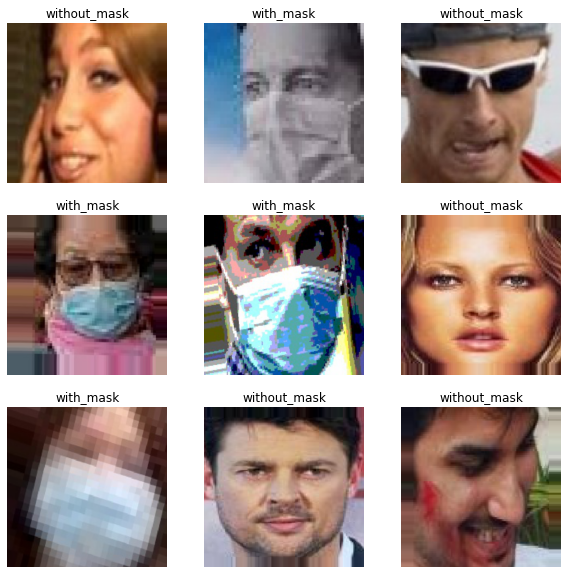

In [ ]:
plot_images(train_generator)

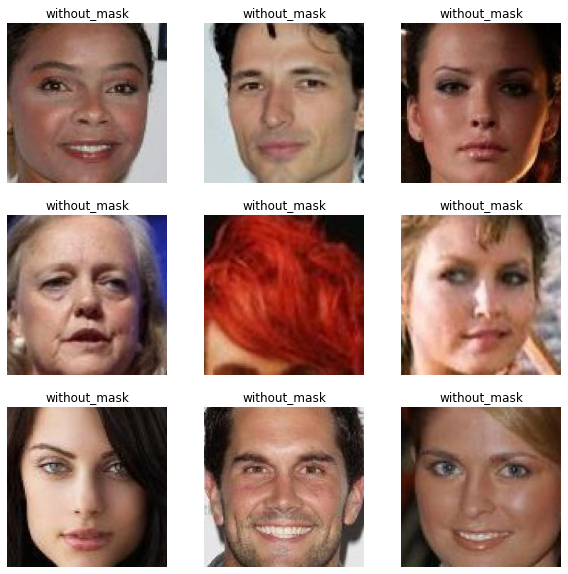

In [ ]:
plot_images(valid_generator)

# Create a baseline model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
history=model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

Epoch 1/3
70/70 [==============================] - 110s 2s/step - loss: 0.5173 - accuracy: 0.8170 - val_loss: 0.4664 - val_accuracy: 0.8791
Epoch 2/3
70/70 [==============================] - 112s 2s/step - loss: 0.1992 - accuracy: 0.9260 - val_loss: 0.3169 - val_accuracy: 0.9113
Epoch 3/3
70/70 [==============================] - 112s 2s/step - loss: 0.1396 - accuracy: 0.9508 - val_loss: 0.1177 - val_accuracy: 0.9697


In [ ]:
predicted_labels=model.predict(test_generator)


In [ ]:
predicted_labels_final=np.argmax(predicted_labels,axis=1)

In [ ]:
predicted_labels_final

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
def save_predictions(df,predicted_labels,folder_path=None,file_name='submission'):
  df['label']=predicted_labels
  df['label']=test_df['label'].apply(lambda x: 'with_mask' if x==0 else 'without_mask')
  if (folder_path is not None)  and  (file_name is not None):
    df.to_csv(folder_path+file_name,index=False)


In [ ]:
test_df['label']=predicted_labels_final

In [ ]:
final_folder_path='/content/drive/My Drive/Face_mask_detection/'

In [ ]:
save_predictions(df=test_df,predicted_labels=predicted_labels_final,folder_path=final_folder_path,file_name='submission_1.csv')

In [ ]:
model.save(final_folder_path+'model_1.h5')

# This model achieves 95.96% accuracy on the test data

# Model 2 - Transfer learning using Xception model with weights trained on imagenet

In [ ]:
IMG_HEIGHT=480
IMG_WIDTH=480

In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2)(x)
model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history=model_3.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

# Let's plot validation, training loss and accuracy graph

In [ ]:
def plot_results(history):
  print(history.history.keys())
#  "Accuracy"
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
history

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


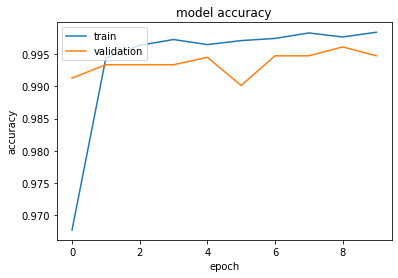

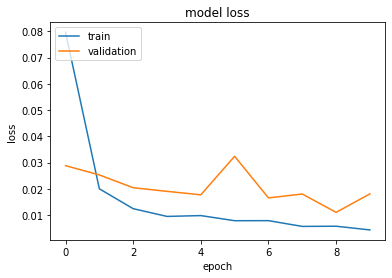

In [ ]:
plot_results(history)

# Let's try for another 1 epoch and see the results

In [ ]:
history=model_3.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1
)

70/70 [==============================] - 414s 6s/step - loss: 0.0050 - binary_accuracy: 0.9981 - val_loss: 0.0152 - val_binary_accuracy: 0.9956


# This model achieves me 99.67% accuracy and got me first position in the competition

# Let's see if we can try for another epoch and see if we get some improvement

In [ ]:
history=model_3.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1
)

70/70 [==============================] - 421s 6s/step - loss: 0.0033 - binary_accuracy: 0.9987 - val_loss: 0.0118 - val_binary_accuracy: 0.9961


# This model achieves me 99.67% accuracy which is same as the previous model. We can stop here.

In [ ]:
predicted_labels=model_3.predict(test_generator)

In [ ]:
predicted_labels=np.argmax(predicted_labels,axis=1)


In [ ]:
save_predictions(df=test_df,predicted_labels=predicted_labels,folder_path=final_folder_path,file_name='submission_final.csv')

In [ ]:
model_3.save(final_folder_path+'transfer_model_best')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Face_mask_detection/transfer_model_best_1/assets


# Conclusion

1. Initial model with 3 convolutional layers + 2 fully connected layers achieved an accuracy of  95.96 % on the test dataset when trained for 3 epochs. All the images were reshaped to (224x244x3)

2. Transfer learning using xception model with weights trained on imagenet + 1 fully connected layer achieved an accuracy of 98.28% on the test dataset when trained for 10 epochs. All the images wer reshaped to (224x224x3).

3. Transfer learning using xception model with weights trained on imagenet + 2 fully connected layer achieved an accuracy of 99.67% on the test dataset when trained for 10 epochs. All the images wer reshaped to (480x480x3).


# Things that can be tried 
1. Increase the number of Fully connected layer from 2 to 3 or increase the number of fully connected layer neurons ( I have used only 128 neurons but can be experimented with 256 or 512 neurons) and check for increase in validation accuracy.

2. I have not used learning rate scheduler for decreasing the learning rate when we train for more epochs. The reason I have not used is because I have trained for only 10 epochs. This might help when we train for more epochs.